In [ ]:
import os
import json
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def extract_generation(filename):
    """Extract generation number from filename."""
    match = re.search(r'_(\d+)\.json$', filename)
    if match:
        return int(match.group(1))
    return None


def process_files(directory, name_prefix):
    # Get all JSON files in the directory that match the name pattern
    # The pattern will look for files like "{name_prefix}_{generation}.json"
    file_pattern = os.path.join(directory, f"{name_prefix}_*.json")
    files = glob.glob(file_pattern)

    # Sort files by generation number
    files.sort(key=extract_generation)

    all_data = []
    generations = []

    for file in files:
        gen_num = extract_generation(file)
        if gen_num is not None:
            generations.append(gen_num)
            with open(file, 'r') as f:
                data = json.load(f)
                all_data.append(data)

    return all_data, generations


def analyze_fitness(all_data, generations):
    # Store fitness data for each generation
    pop_fitness = {
        'avg': [],
        'min': [],
        'max': []
    }

    best_species_fitness = {
        'avg': [],
        'min': [],
        'max': []
    }

    # Count species in each generation
    species_count = []

    for data in all_data:
        # Extract all genomes from all species
        all_genomes = []
        species_fitness_data = []

        # Count species in this generation
        species_in_gen = len(data.get('Species', []))
        species_count.append(species_in_gen)

        for species in data.get('Species', []):
            species_genomes = species.get('Genomes', [])
            all_genomes.extend(species_genomes)

            # Calculate fitness stats for this species
            if species_genomes:
                fitness_values = [genome.get('Fitness', 0.0)
                                  for genome in species_genomes]
                species_fitness_data.append({
                    'avg': np.mean(fitness_values),
                    'min': np.min(fitness_values),
                    'max': np.max(fitness_values)
                })

        # Calculate population-wide fitness stats
        if all_genomes:
            fitness_values = [genome.get('Fitness', 0.0)
                              for genome in all_genomes]
            pop_fitness['avg'].append(np.mean(fitness_values))
            pop_fitness['min'].append(np.min(fitness_values))
            pop_fitness['max'].append(np.max(fitness_values))
        else:
            pop_fitness['avg'].append(0)
            pop_fitness['min'].append(0)
            pop_fitness['max'].append(0)

        # Find best species (with highest average fitness)
        if species_fitness_data:
            best_species_idx = np.argmax(
                [species['avg'] for species in species_fitness_data])
            best_species = species_fitness_data[best_species_idx]
            best_species_fitness['avg'].append(best_species['avg'])
            best_species_fitness['min'].append(best_species['min'])
            best_species_fitness['max'].append(best_species['max'])
        else:
            best_species_fitness['avg'].append(0)
            best_species_fitness['min'].append(0)
            best_species_fitness['max'].append(0)

    return pop_fitness, best_species_fitness, species_count


def plot_fitness_data(generations, pop_fitness, best_species_fitness, name_prefix):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Entire Population
    ax1.plot(generations, pop_fitness['avg'], 'b-', label='Average Fitness')
    ax1.plot(generations, pop_fitness['min'], 'r-', label='Minimum Fitness')
    ax1.plot(generations, pop_fitness['max'], 'g-', label='Maximum Fitness')
    ax1.set_title(f'Fitness Statistics for Entire Population ({name_prefix})')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Best Species
    ax2.plot(
        generations, best_species_fitness['avg'], 'b-', label='Average Fitness')
    ax2.plot(
        generations, best_species_fitness['min'], 'r-', label='Minimum Fitness')
    ax2.plot(
        generations, best_species_fitness['max'], 'g-', label='Maximum Fitness')
    ax2.set_title(f'Fitness Statistics for Best Species ({name_prefix})')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


def plot_species_count(generations, species_count, name_prefix):
    """Plot the number of species across generations."""
    plt.figure(figsize=(10, 6))
    plt.plot(generations, species_count, 'b-o', linewidth=2)
    plt.title(f'Number of Species per Generation ({name_prefix})')
    plt.xlabel('Generation')
    plt.ylabel('Number of Species')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def visualize_fitness(directory: str, name_prefix: str):
    all_data, generations = process_files(directory, name_prefix)

    if not all_data:
        print(f"No valid JSON files found with prefix '{name_prefix}'!")
        return

    pop_fitness, best_species_fitness, species_count = analyze_fitness(
        all_data, generations)
    plot_fitness_data(generations, pop_fitness,
                      best_species_fitness, name_prefix)
    plot_species_count(generations, species_count, name_prefix)

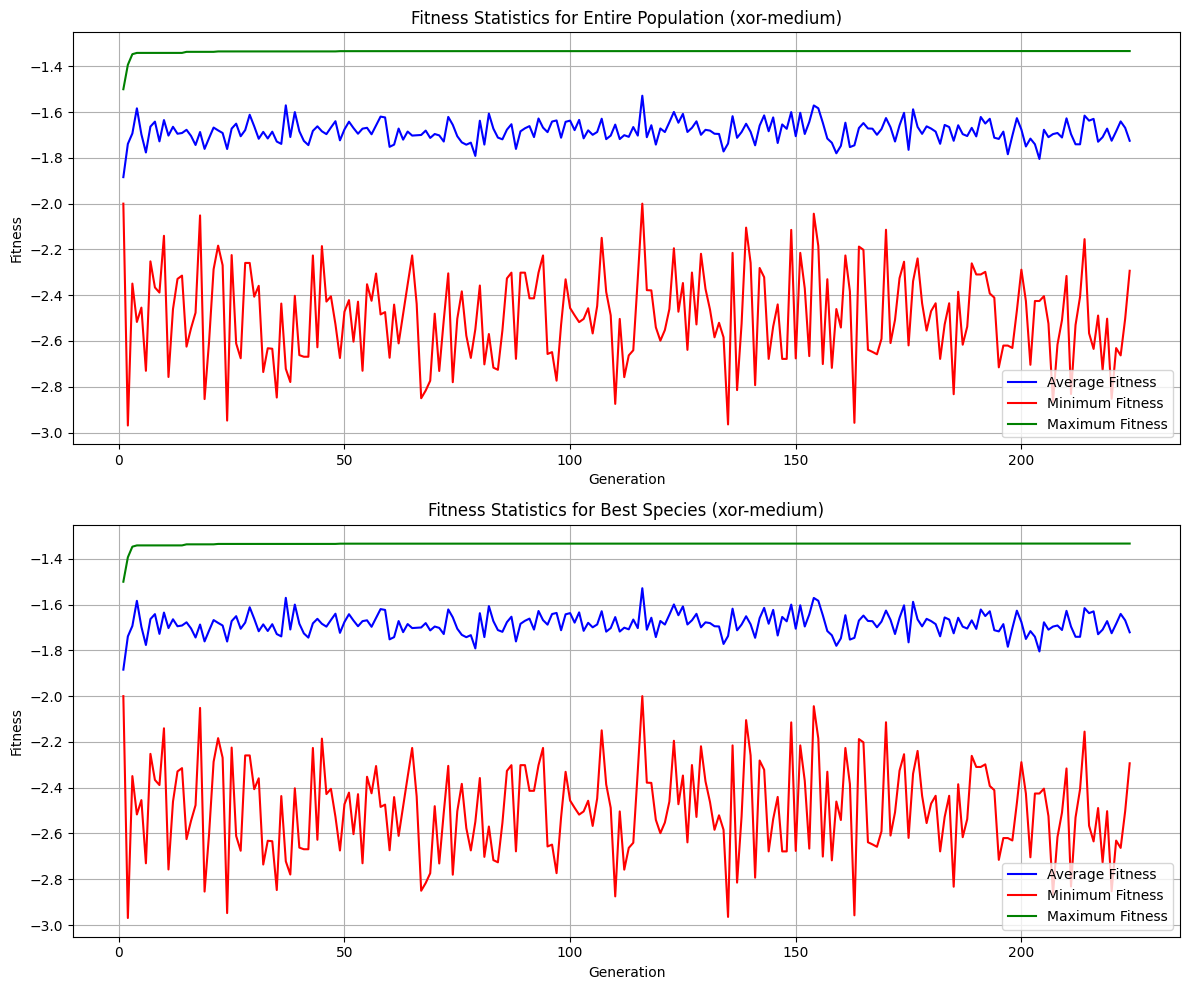

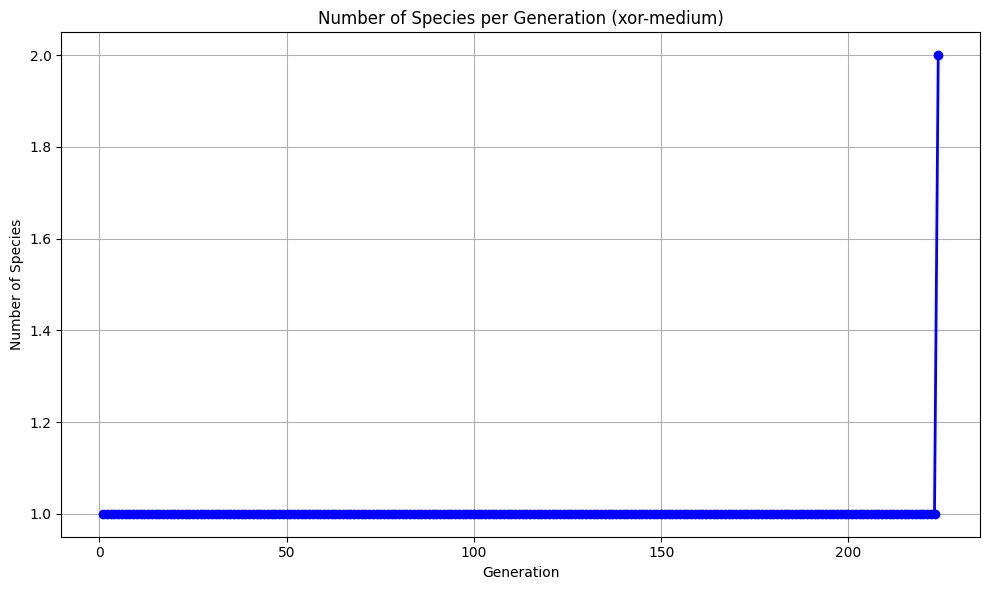

In [15]:
visualize_fitness("../data", "xor-medium")